In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials import firing_rate
from ephysvibe.dataviz import plot_raster
from ephysvibe.stats import smetrics

In [15]:
path='//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/2022-11-30_10-42-03_Riesling_lip_e1_r1_mua5_neu.h5'
neu = NeuronData.from_python_hdf5(path)
nid = neu.get_neuron_id() 

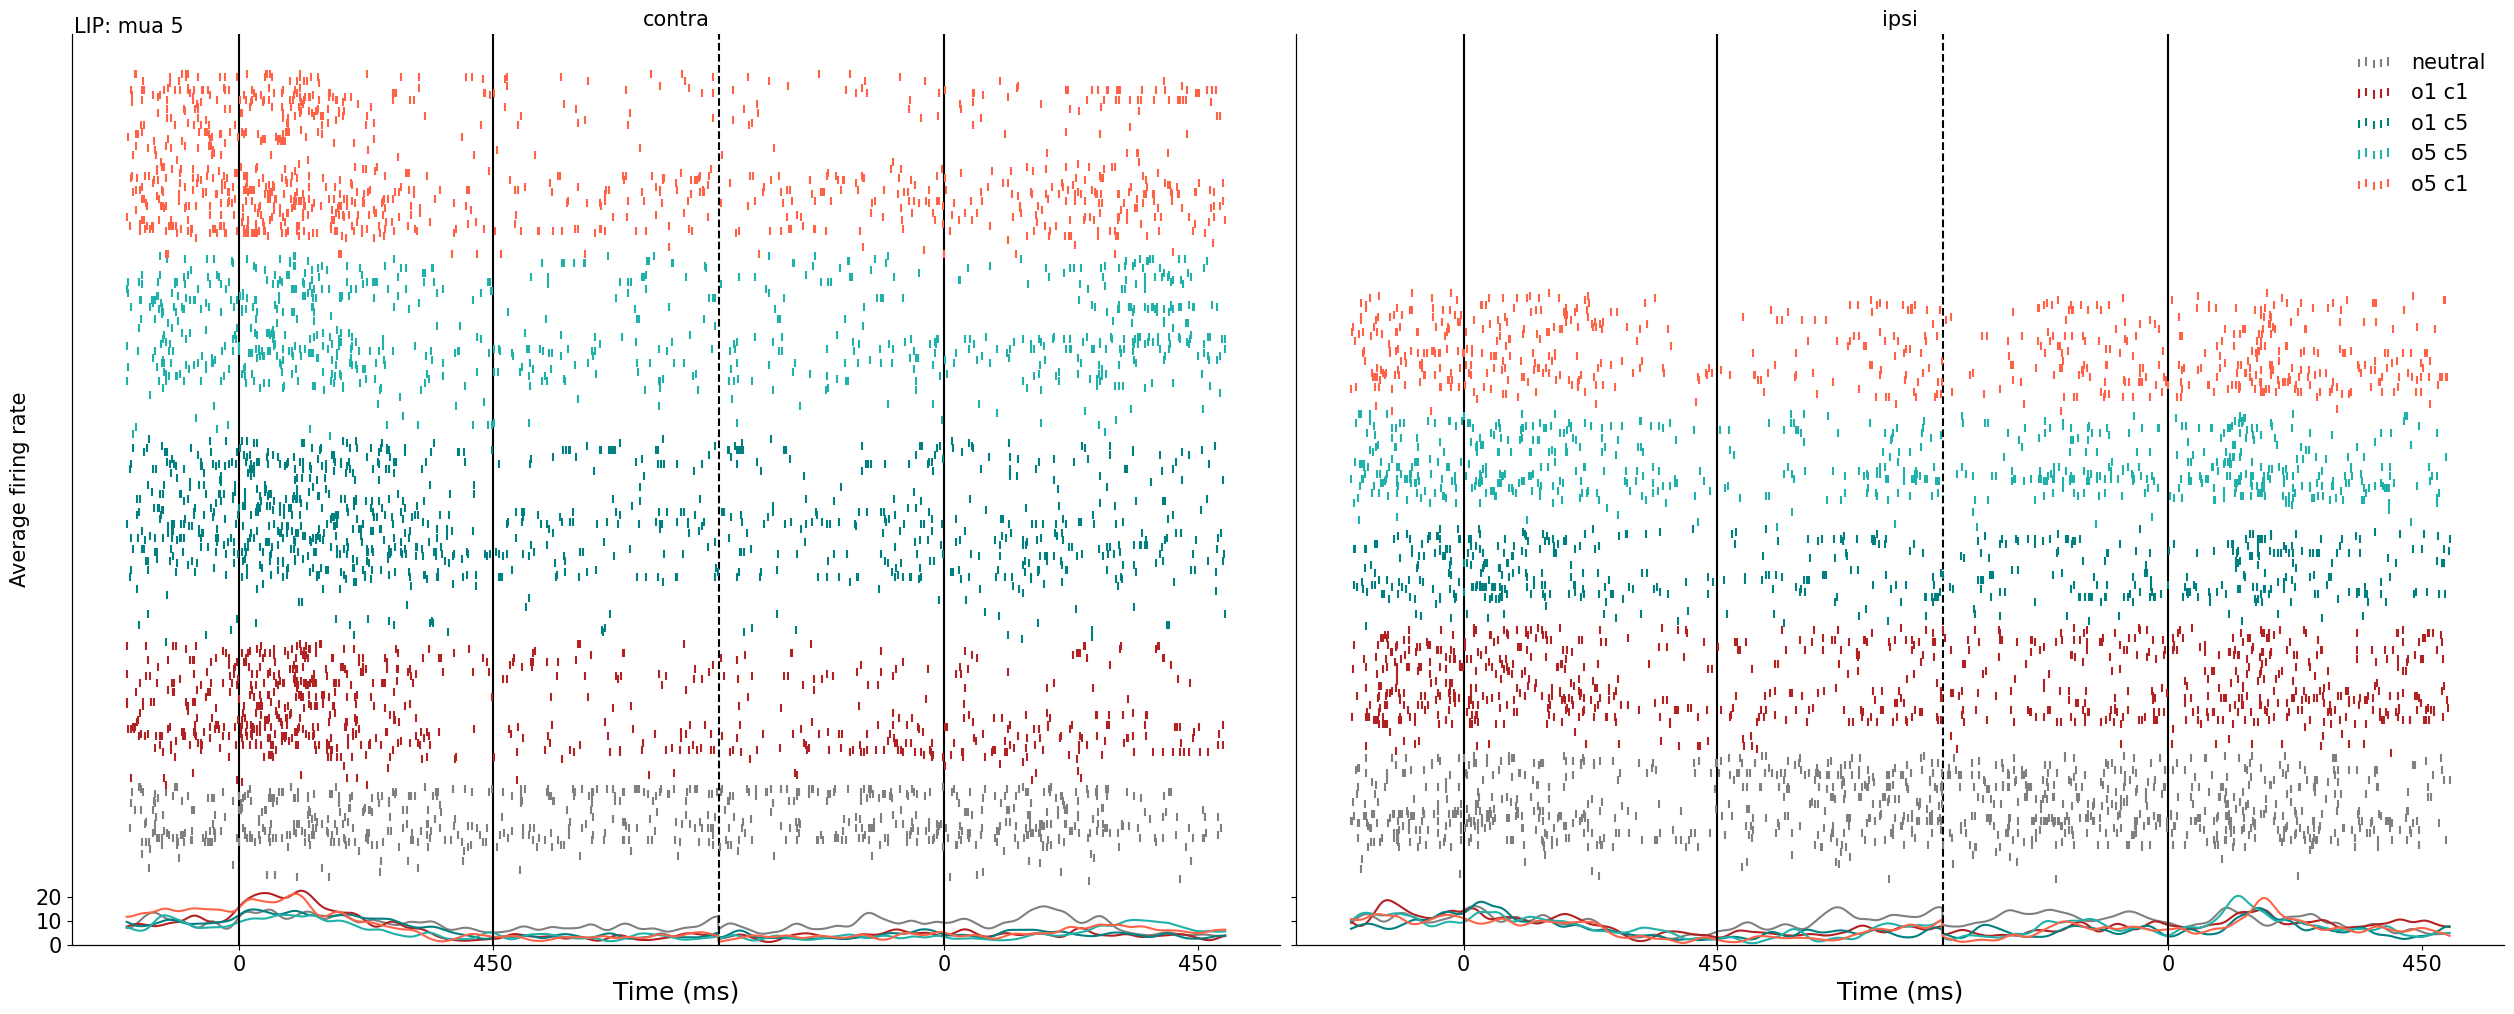

In [16]:
sp, conv = plot_raster.prepare_data_plotb1(neu,rf_stim_loc= ["contra", "ipsi"],cerotr=True,percentile=True)
fig=plot_raster.plot_sp_b1(neu,sp, conv)
#fig.savefig('pp.svg',format='svg')

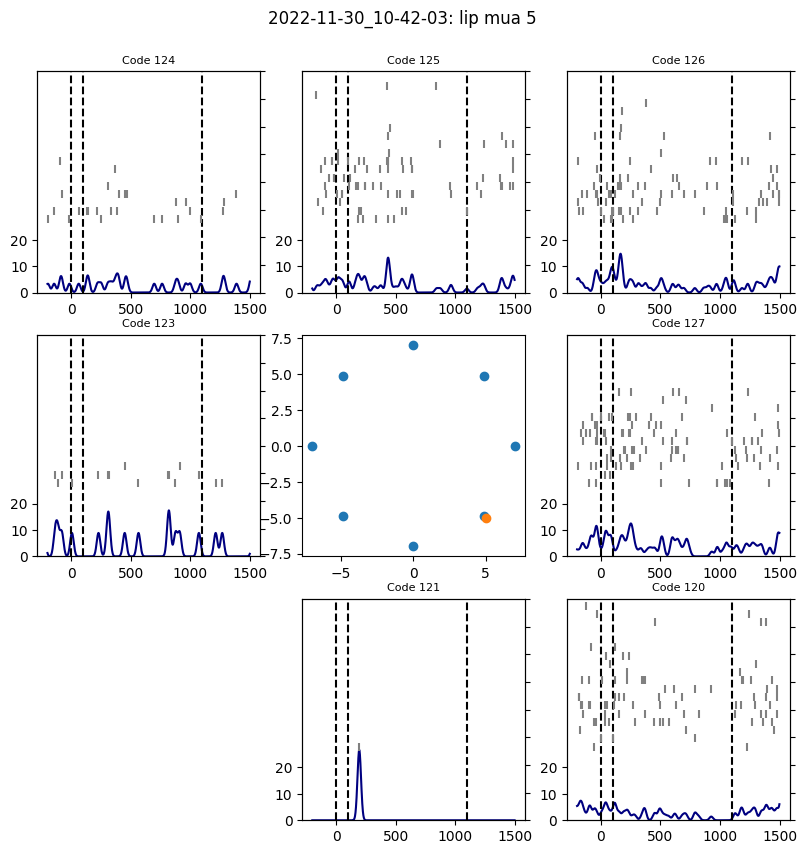

In [17]:
sp_pos, conv_pos, max_n_tr, conv_max = plot_raster.prepare_data_plotb2(neu)
fig = plot_raster.plot_sp_b2(neu,sp_pos, conv_pos, max_n_tr, conv_max, visual_rf=True,inout=1)

In [18]:
stats.ttest_rel(np.mean(sp_pos['120'][:,:200],axis=1), np.mean(sp_pos['120'][:,200:400],axis=1))

TtestResult(statistic=np.float64(-0.4898979485566353), pvalue=np.float64(0.6301235861174145), df=np.int64(18))

In [19]:
orientation1 = np.concatenate([sp['contra']['11'],sp['contra']['15']],axis=0)
o_avg1 = firing_rate.moving_average(
    orientation1, win=100, step=1
)
orientation5 = np.concatenate([sp['contra']['51'],sp['contra']['55']],axis=0)
o_avg5 = firing_rate.moving_average(
    orientation5, win=100, step=1
)

color1 = np.concatenate([sp['contra']['11'],sp['contra']['51']],axis=0)
c_avg1 = firing_rate.moving_average(
    color1, win=100, step=1
)
color5 = np.concatenate([sp['contra']['15'],sp['contra']['55']],axis=0)
c_avg5 = firing_rate.moving_average(
    color5, win=100, step=1
)

non_neutral = np.concatenate([sp['contra']['15'],sp['contra']['55'],sp['contra']['11'],sp['contra']['51']],axis=0)
non_neutral = firing_rate.moving_average(
    non_neutral, win=100, step=1
)
neutral = sp['contra']['0']
neutral = firing_rate.moving_average(
    neutral, win=100, step=1
)

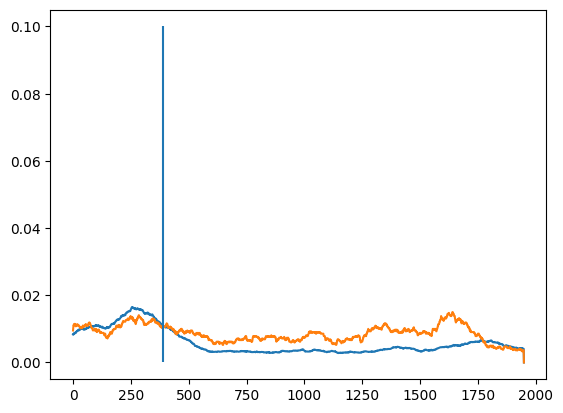

In [20]:
plt.plot(np.mean(non_neutral,axis=0))
plt.plot(np.mean(neutral,axis=0))
plt.vlines(390,0,0.1)

In [21]:
PALETTE_B1 = {
    "11": "firebrick",  # o1_c1
    "15": "teal",  # o1_c5
    "51": "tomato",  # o5_c1
    "55": "lightseagreen",  # o5_c5
    "0": "grey",  # o0_c0
}

In [22]:
non_neutral[:,454]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.02, 0.02, 0.02, 0.03, 0.01,
       0.  , 0.01, 0.02, 0.01, 0.01, 0.03, 0.05, 0.04, 0.01, 0.  , 0.02,
       0.01, 0.02, 0.01, 0.01, 0.03, 0.04, 0.  , 0.02, 0.  , 0.02, 0.03,
       0.01, 0.02, 0.  , 0.03, 0.01, 0.  , 0.06, 0.02, 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.01, 0.  , 0.03, 0.  ,
       0.01, 0.03, 0.  , 0.02, 0.  , 0.02, 0.02, 0.05, 0.  , 0.01, 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.01,
       0.01, 0.  , 0.01, 0.  , 0.02, 0.  , 0.  , 0.  , 0.03, 0.  , 0.02,
       0.01, 0.01, 0.  , 0.  , 0.  , 0.04, 0.  , 0.01, 0.  , 0.01, 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.01, 0.

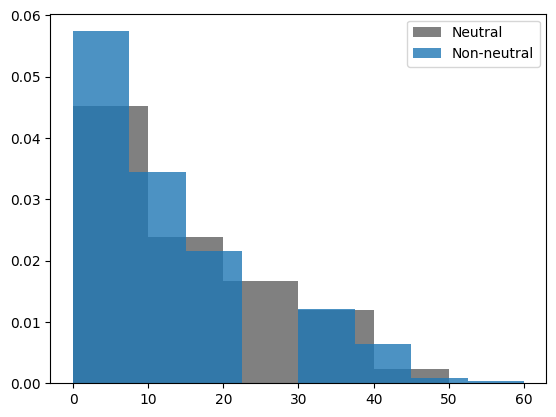

In [23]:
plt.hist(neutral[:,390]*1000,bins=5,color='grey',density=True,label='Neutral')
plt.hist(non_neutral[:,390]*1000,bins=8,density=True, alpha=.8,label='Non-neutral')
plt.legend()


In [24]:
color_lat, color_score, color_p = smetrics.get_selectivity(
    non_neutral, neutral, win=75, scores=True
)

In [25]:
color_lat-200

np.int64(798)

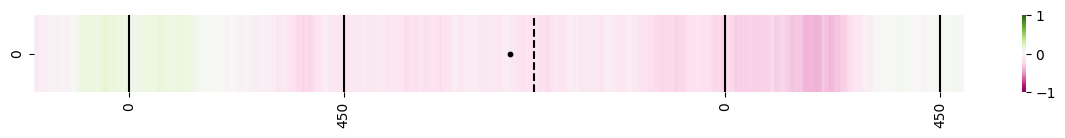

In [26]:
fig,ax=plt.subplots(figsize=(15,1))
sns.heatmap([color_score], vmin=-1, vmax=1, cmap='PiYG',ax=ax)
ax.scatter(color_lat,np.arange(len([color_lat]))+0.5,s=10,color='k')
x_ticks = [200,650,1450,1900]
ax.set_xticks(x_ticks)
ax.set_xticklabels(["0", "450", "0", "450"])

ax.vlines([200,650,1450,1900],ax.get_ylim()[0],ax.get_ylim()[1],'k','-')
ax.vlines([1050],ax.get_ylim()[0],ax.get_ylim()[1],'k','--')